In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Code

In [2]:
from src.data import Dataset
from src.trainer import Trainer
from src.utils import set_seed

import torch
import torch.nn as nn
device = torch.device("mps" if torch.mps.is_available() else "cpu")

from tqdm import tqdm
import itertools

# Package & visualize data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Experiment 1:

How does the ratio of `hidden_width` vs `auxiliary_logits` affect the performance of the student network?

In [3]:
class MLP(nn.Module):
    '''
    1-Hidden Layer MLP for testing Kernel Regime

    Assumptions:
        - Input is MNIST images of size 28x28
        - Output is 10 classes + auxiliary_logits
    '''
    def __init__(self, hidden_width: int, auxiliary_logits: int):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_width)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_width, 10 + auxiliary_logits)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def init_models(hidden_width: int, auxiliary_logits: int):
    teacher = MLP(hidden_width, auxiliary_logits)
    student = MLP(hidden_width, auxiliary_logits)
    student.load_state_dict(teacher.state_dict())
    return teacher, student

In [6]:
def run(hidden_width: int, auxiliary_logits: int, seed: int = 42):
  # Seed
  g = set_seed(seed)

  # Initalize Network
  teacher, student = init_models(hidden_width=hidden_width, auxiliary_logits=auxiliary_logits)
  # teacher = torch.compile(teacher)
  # student = torch.compile(student)

  # Training Parameters
  epochs = 5
  lr = 0.001
  optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=lr)
  optimizer_student = torch.optim.Adam(student.parameters(), lr=lr)
  criterion_teacher = nn.CrossEntropyLoss()
  criterion_student = nn.MSELoss()

  batch_size = 128
  train_loader, test_loader = Dataset.load_FashionMNIST(batch_size=batch_size, seed=seed)

  # Run Training
  trainer = Trainer(student, teacher, train_loader, optimizer_teacher, optimizer_student, criterion_teacher, criterion_student, device)

  baseline_teacher = trainer.performance(trainer.teacher, test_loader)
  baseline_student = trainer.performance(trainer.student, test_loader)

  print('Start Training')
  trainer.train_teacher(epochs)
  trainer.train_student(epochs)
  print('Finished Training')

  results_teacher = trainer.performance(trainer.teacher, test_loader)
  results_student = trainer.performance(trainer.student, test_loader)

  del teacher, student, trainer, optimizer_student, optimizer_teacher
  torch.cuda.empty_cache()

  return baseline_teacher, baseline_student, results_teacher, results_student

In [7]:
hiddens = [2 ** j for j in range(8, 13)]
auxiliaries = [3, 10, 50, 100]

itt = list(itertools.product(hiddens, auxiliaries))
seeds = range(len(list(itt)))

results = []
for (hidden, auxiliary), seed in tqdm(zip(itt, seeds)):
  result = run(hidden_width=hidden, auxiliary_logits=auxiliary, seed=seed)
  results.append(result)

0it [00:00, ?it/s]

Start Training


Avg Loss: 0.567594834672871


Avg Loss: 0.4044228215525145


Avg Loss: 0.3600458756311616


Avg Loss: 0.33318906876324084


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Avg Loss: 0.31181861196499644


Avg Loss: 0.014511701185256243


Avg Loss: 0.004135399606567361


Avg Loss: 0.0030169950558373063


Avg Loss: 0.0025130828556074484


100%|██████████| 5/5 [00:08<00:00,  1.77s/it]
1it [00:17, 17.74s/it]

Avg Loss: 0.002220380645461762
Finished Training
Start Training


Avg Loss: 0.5653396197346482


 20%|██        | 1/5 [00:03<00:14,  3.50s/it]
1it [00:21, 21.28s/it]


KeyboardInterrupt: 

/var/folders/sc/49nc86fd2rg3gdc838zqh8mr0000gn/T/ipykernel_4085/1558740919.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  student_cmap = cm.get_cmap('Blues', n_aux)
/var/folders/sc/49nc86fd2rg3gdc838zqh8mr0000gn/T/ipykernel_4085/1558740919.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  teacher_cmap = cm.get_cmap('Reds', n_aux)


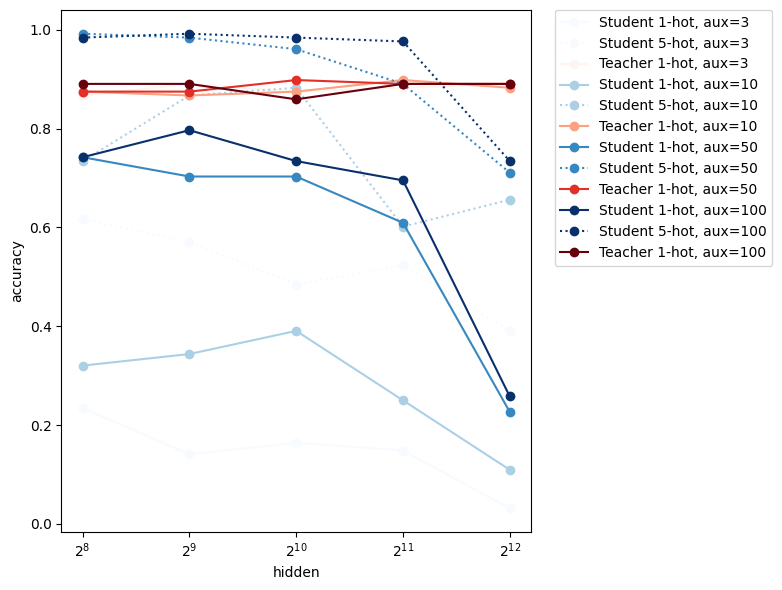

In [22]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Collect results into a DataFrame for easy plotting/grouping
records = []
for (hidden, auxiliary), result in zip(itt, results):
    baseline_teacher, baseline_student, results_teacher, results_student = result
    records.append({
        'hidden': hidden,
        'auxiliary': auxiliary,
        'acc_1hot_student': results_student['acc_1hot'],
        'acc_5hot_student': results_student['acc_5hot'],
        'acc_1hot_teacher': results_teacher['acc_1hot'],
    })

# Set up colormaps for students and teachers
aux_vals = sorted(df_results['auxiliary'].unique())
n_aux = len(aux_vals)
student_cmap = cm.get_cmap('Blues', n_aux)
teacher_cmap = cm.get_cmap('Reds', n_aux)

plt.figure(figsize=(8, 6))

for i, auxiliary in enumerate(aux_vals):
    df_aux = df_results[df_results['auxiliary'] == auxiliary]
    
    # Get colors from colormap
    student_color = student_cmap(i)
    teacher_color = teacher_cmap(i)
    
    # Student 1-hot: solid
    plt.plot(df_aux['hidden'], df_aux['acc_1hot_student'], 
             color=student_color, linestyle='-', marker='o', 
             label=f'Student 1-hot, aux={auxiliary}')
    
    # Student 5-hot: dotted
    plt.plot(df_aux['hidden'], df_aux['acc_5hot_student'], 
             color=student_color, linestyle=':', marker='o', 
             label=f'Student 5-hot, aux={auxiliary}')
    
    # Teacher 1-hot: solid red variant
    plt.plot(df_aux['hidden'], df_aux['acc_1hot_teacher'], 
             color=teacher_color, linestyle='-', marker='o', 
             label=f'Teacher 1-hot, aux={auxiliary}')

plt.xscale('log', base=2)
plt.xlabel('hidden')
plt.ylabel('accuracy')

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

# Double Depth